In [1]:
import numpy as np
import re
import json
import matplotlib.pyplot as plt

In [2]:
def is_correct(a,b,sum):
    return a+b == sum

def get_un_digits(num):
    return len(str(num).replace('-',''))

In [3]:
# first process all the lines and get a list of processed lines
## 1 some lines start with =, which actually needs to be appended to the previous line
## 2 some lineas are empty, or have only 0, such lines need to be removed
## processed lines still have issues, which will be addressed at time of extracting numbers

processed_lines = []

with open('gemini_response/int_addition_response.txt','r') as file:
    for line in file:
        # remove leading and trailing spaces
        line = line.strip()

        # if line starts with '=' append it to the previous line
        if line.startswith('='):
            # previous line is updated
            # first line does not start with =, so processed_lines is not empty
            processed_lines[-1] = processed_lines[-1] + line
        elif line.startswith('`'):
            # line only contains the backtick, so ignore it
            continue
        elif line and line !='0':
            # if line is not empty, add it to the processed lines
            processed_lines.append(line)

print('Number of processed lines:', len(processed_lines))

Number of processed lines: 23649


In [4]:
# get total number of lines in input file to the gemini
with open('../../data/int_addition.json','r') as ipfile:
    input_examples = json.load(ipfile)
print('Number of expamples in input file:', len(input_examples))

# delete the input file as it is not needed anymore
del input_examples

Number of expamples in input file: 24000


**out of 24000 lines, we got response (may not be in valid format) for 23649 lines only, which is 98.53%**

In [5]:
MAX_DIGITS =60
correct = np.zeros((3, MAX_DIGITS))
total = np.zeros((3, MAX_DIGITS))
error_lines = 0
errors={'Only a, no b':[], 'a+b or =sum':[], 'a+b+-d=sum':[], '=c+-d':[], '= (empty)':[]}

# extract numbers from the processed lines, and update the correct and total arrays
for line in processed_lines:
    # some lines have numbering at start, eg 1. a + b = sum,
    # remove the numbering and dot if present
    line = re.sub(r'^\d+\.\s*','',line)

    # some numbers have brackets and stars around them, eg (a) or *a*, remove them
    line = re.sub(r'[(),*]','',line)

    # some numbers have E and some have e, convert all to e
    line = re.sub(r'E','e',line)

    # some lines are like a+b+c=a-b=sum, hence to extract a, split by + and take the first element
    try:
        a,b = line.split('+',1)
    except ValueError:
        # some lines have only a, such lines are not useful
        # these will not be considered
        errors['Only a, no b'].append(line)
        error_lines+=1
        continue

    # to extract b, split by = and take the first element
    try:
        b,c = b.split('=',1)
    except ValueError:
        # some lines have only a+b, without =sum, such lines are not useful
        # or only =sum, such lines are not useful
        # these will not be considered
        errors['a+b or =sum'].append(line)
        error_lines+=1
        continue
        

    b = b.split('+')[0]
    if re.match(r'\d+-\d+',b.strip()):
        # some lines have a+b-c+d=sum, such lines are not useful
        # these will not be considered
        errors['a+b+-d=sum'].append(line)
        error_lines+=1
        continue

    # split at last = to get the sum
    sum = c.split('=')[-1]
    if '+' in sum.split() or '-' in sum.split():
        # some lines have a+b+c=a+b, such lines are not useful
        # these will not be considered
        errors['=c+-d'].append(line)
        error_lines+=1
        continue
    elif sum=='':
        # some lines have a+b+c=, such lines are not useful
        # these will not be considered
        errors['= (empty)'].append(line)
        error_lines+=1
        continue

    # convert into integers or float
    # sum numbers are in scientific notation, so convert them to float
    a = float(a) if 'e'  in a else int(a)
    b = float(b) if 'e' in b else int(b)
    sum = float(sum) if 'e' in c else int(sum)
    # get the number of digits in each number
    num_digits = get_un_digits(a)

    # update the total array depending on the number of digits and sign of the numbers
    if a>=0 and b>=0:
        total[0,num_digits-1] += 1
        correct[0,num_digits-1] += is_correct(a,b,sum)
    
    elif a<0 and b<0:
        total[2,num_digits-1] += 1
        correct[2,num_digits-1] += is_correct(a,b,sum)
    
    else:
        total[1,num_digits-1] += 1
        correct[1,num_digits-1] += is_correct(a,b,sum)

In [6]:
# print error lines
for key in errors:
    print('Error ',key,', number of lines:',len(errors[key]))
    for line in errors[key]:
        print(line)
    print('==============================================================')

Error  Only a, no b , number of lines: 5
= -479702931803901969364625002504275206616227643030425
= -1.0662553826397175385470766937775155450968187588677
= -1.30532278812142745333704897853115792808955220794275  10^12
= -1.17481635308839632227610711028793390688914639401111  10^12
= -1.32439825960486322409862146953927436364687070978892  10^12
Error  a+b or =sum , number of lines: 7
-9184341364151385972798842826139351 + -8
= -1.4758021115088010423691892504645241405406786900231e+24
= -5.2585375064611876885190510231548044820664796415761e+23
= -1.2767209120332134822859446417425566689034231818849e+24
= -1.4588731407268918762065054866910365444819287112316e+24
= -7.7319736432919043435208070428904568739051351284833e+23
-7284660012500964758846082746586373289229935235652266644 + -6249356772635677133199848596262
Error  a+b+-d=sum , number of lines: 0
Error  =c+-d , number of lines: 125
9404289058174976814608958911690659669 + 8430491626343106179765984849588275380 = 9404289058174976814608958911690659669

In [7]:
print('total examples without syntax errors:', total.sum())

total examples without syntax errors: 23511.0


test examples: 24000 <br>
valid response: 23511 <br>
% of valid response: 97.96% <br>

for each digit, test examples were 400 <br>

In [8]:
num_examples = np.ones_like(total)*np.array([[100], # both (a and b) positive
                                             [200], # a and b different signs
                                             [100]]) # both (a and b) negative

In [9]:
valid_responses=total*100/num_examples


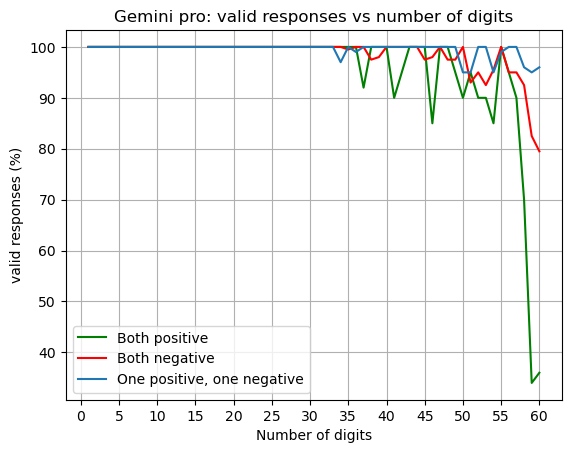

In [10]:
# plot the valid responses as a function of number of digits
plt.plot(np.arange(1,61),valid_responses[0],color='green',label='Both positive')
plt.plot(np.arange(1,61),valid_responses[1],color='red',label='Both negative')
plt.plot(np.arange(1,61),valid_responses[2],label='One positive, one negative')
plt.xticks(np.arange(0,65,5))
plt.xlabel('Number of digits')
plt.ylabel('valid responses (%)')
plt.title('Gemini pro: valid responses vs number of digits')
plt.grid()
plt.legend()
plt.savefig('gemini_response/plots/Int_addn_valid_responses_vs_digits.png')
plt.show()

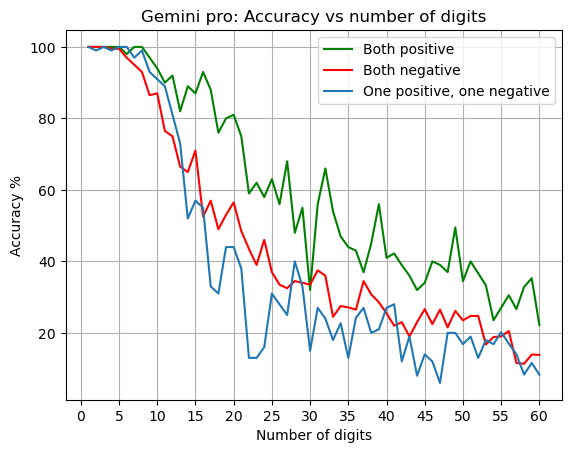

In [11]:
accuracy = correct*100/total

# plot the accuracy as a function of number of digits
plt.plot(np.arange(1,61),accuracy[0],color='green',label='Both positive')
plt.plot(np.arange(1,61),accuracy[1],color='red',label='Both negative')
plt.plot(np.arange(1,61),accuracy[2],label='One positive, one negative')
plt.xticks(np.arange(0,65,5))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Accuracy vs number of digits')
plt.grid()
plt.legend()
plt.savefig('gemini_response/plots/Int_addn_accuracy_vs_digits.png')
plt.show()